# Richly Activated Graph Convolutional Network on HRI dataset

We define a custom dataset that will be used to create training/test datasets. This will also help to create a DataLoader.

In [58]:
from torchvision import transforms

action_class = {'A001': 'Stop', 'A002': 'Go Right', 'A003': 'Go Left', 'A004': 'Come Here', 'A005': 'Follow me',
                'A006': 'Go Away', 'A007': 'Agree', 'A008': 'Disagree', 'A009': 'Go there', 'A010': 'Get Attention',
                'A011': 'Be Quiet', 'A012': 'Dont Know', 'A013': 'Turn Around', 'A014': 'Take This',
                'A015': 'Pick Up', 'A016': 'Standing Still', 'A017': 'Being Seated', 'A018': 'Walking Towards',
                'A019': 'Walking Away', 'A020': 'Talking on Phone'}
lab_to_num = {'Stop': 0, 'Go Right': 1, 'Go Left': 2, 'Come Here': 3, 'Follow me': 4, 'Go Away': 5, 'Agree': 6, 'Disagree': 7,
              'Go there': 8, 'Get Attention': 9, 'Be Quiet': 10, 'Dont Know': 11, 'Turn Around': 12, 'Take This': 13,
              'Pick Up': 14, 'Standing Still': 15, 'Being Seated': 16, 'Walking Towards': 17, 'Walking Away': 18,
              'Talking on Phone': 19}
joint_dict = {'Nose': 0, 'LEye': 1, 'REye': 2, 'LEar': 3, 'REar': 4, 'LShoulder': 5, 'RShoulder': 6, 'LElbow': 7,
              'RElbow': 8, 'LWrist': 9, 'RWrist': 10, 'LHip': 11, 'RHip': 12, 'LKnee': 13, 'RKnee': 14,
              'LAnkle': 15, 'RAnkle': 16}

In [59]:
# from google.colab import drive
# drive.mount('/content/drive')

In [60]:
labels_to_learn = ['Stop', 'Standing Still', 'Follow me']

Next we will define the RA-GCN. This is based on the original RA-GCN implementation from:
Song, Yi-Fan, Zhang Zhang, and Liang Wang. "Richly activated graph convolutional network for action recognition with incomplete skeletons." 2019 IEEE International Conference on Image Processing (ICIP). IEEE, 2019.

In [61]:
import os
import random
import numpy as np
from torch.utils.data import Dataset


class NTU(Dataset):
    def __init__(self, path, train, train_split, data_shape, transform=None, mode='default'):

        self.train = train
        self.path = path
        self.maxC, self.maxT, self.maxV, self.maxM = data_shape
        self.transform = transform
        self.files_in = []
        self.files = []

        for dirpath, dirnames, filenames in os.walk(self.path):
          self.files_in.append(filenames)

        self.files_in = self.files_in[1:]

        # Remove all data except labels in labels_to_learn
        for dic in range(len(self.files_in)):
          for file in self.files_in[dic]:
            lab = action_class[file[:4]]
            if lab in labels_to_learn:
              self.files.append(file)
                    
        random.shuffle(self.files)
        
        if mode == 'default':
            if self.train == 'train':
              self.files = self.files[:int(len(self.files) * train_split)]
            elif self.train == 'eval':
              self.files = self.files[int(len(self.files) * train_split):]
        elif mode == 'cross-subject':
            if self.train == 'train':
                self.files = [file for file in self.files if int(file[6:8]) < 18]
            elif self.train == 'eval':
                self.files = [file for file in self.files if int(file[6:8]) >= 18]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name = self.files[idx].strip()

        data = np.zeros((self.maxC, self.maxT, self.maxV, self.maxM))
        location = np.zeros((2, self.maxT, self.maxV, self.maxM))
        with open(self.path + file_name[4:8] + '/' + file_name, 'r') as fr:
            frame_num = int(fr.readline())
            label = labels_to_learn.index(action_class[file_name[:4]])
            for frame in range(frame_num):
                if frame >= self.maxT:
                    break
                joint_num = int(fr.readline())
                for joint in range(joint_num):
                    v = fr.readline().split(' ')
                    if joint < self.maxV:
                        data[0,frame,joint,0] = float(v[1])
                        data[1,frame,joint,0] = float(v[2])
                        # [2,frame,joint,0] = float(v[3])
                        location[0,frame,joint,0] = float(v[4])
                        location[1,frame,joint,0] = float(v[5])

        if frame_num <= self.maxT:
            data = data[:,:self.maxT,:,:]
        else:
            s = frame_num // self.maxT
            r = random.randint(0, frame_num - self.maxT * s)
            new_data = np.zeros((self.maxC, self.maxT, self.maxV, self.maxM))
            for i in range(self.maxT):
                new_data[:,i,:,:] = data[:,r+s*i,:,:]
            data = new_data

        if self.transform:
            data = self.transform(data)

        data = torch.from_numpy(data).float()
        location = torch.from_numpy(location).float()
        label = torch.from_numpy(np.array(label)).long()
        return data, location, label, file_name

In [62]:
from torch import nn

class RA_GCN(nn.Module):
    def __init__(self, data_shape, num_class, A, drop_prob, gcn_kernel_size, model_stream):
        super().__init__()

        C, T, V, M = data_shape
        self.register_buffer('A', A)

        # baseline
        self.stgcn_stream = nn.ModuleList((
            ST_GCN(data_shape, num_class, A, drop_prob, gcn_kernel_size)
            for _ in range(model_stream)
        ))

        # mask
        self.mask_stream = nn.ParameterList([
            nn.Parameter(torch.ones(T * V))
            for _ in range(model_stream)
        ])


    def forward(self, inp):

        # multi stream
        out = 0
        feature = []
        for stgcn, mask in zip(self.stgcn_stream, self.mask_stream):
            x = inp

            # mask
            N, C, T, V, M = x.shape
            x = x.view(N, C, -1)
            x = x * mask[None,None,:]
            x = x.view(N, C, T, V, M)

            # baseline
            temp_out, temp_feature = stgcn(x)

            # output
            out += temp_out
            feature.append(temp_feature)
        return out, feature


class ST_GCN(nn.Module):
    def __init__(self, data_shape, num_class, A, drop_prob, gcn_kernel_size):
        super().__init__()

        C, T, V, M = data_shape
        self.register_buffer('A', A)

        # data normalization
        self.data_bn = nn.BatchNorm1d(C * V * M)

        # st-gcn networks
        self.st_gcn_networks = nn.ModuleList((
            st_gcn_layer(C, 64, gcn_kernel_size, 1, A, drop_prob, residual=False),
            st_gcn_layer(64, 64, gcn_kernel_size, 1, A, drop_prob),
            st_gcn_layer(64, 64, gcn_kernel_size, 1, A, drop_prob),
            st_gcn_layer(64, 64, gcn_kernel_size, 1, A, drop_prob),
            st_gcn_layer(64, 128, gcn_kernel_size, 2, A, drop_prob),
            st_gcn_layer(128, 128, gcn_kernel_size, 1, A, drop_prob),
            st_gcn_layer(128, 128, gcn_kernel_size, 1, A, drop_prob),
            st_gcn_layer(128, 256, gcn_kernel_size, 2, A, drop_prob),
            st_gcn_layer(256, 256, gcn_kernel_size, 1, A, drop_prob),
            st_gcn_layer(256, 256, gcn_kernel_size, 1, A, drop_prob),
        ))

        # edge importance weights
        self.edge_importance = nn.ParameterList([nn.Parameter(torch.ones(A.shape)) for _ in self.st_gcn_networks])

        # fcn
        self.fcn = nn.Conv2d(256, num_class, kernel_size=1)

    def forward(self, x):

        # data normalization
        N, C, T, V, M = x.shape
        x = x.permute(0, 4, 3, 1, 2).contiguous()
        x = x.view(N, M * V * C, T)
        x = self.data_bn(x)
        x = x.view(N, M, V, C, T)
        x = x.permute(0, 1, 3, 4, 2).contiguous()
        x = x.view(N * M, C, T, V)

        # forward
        for gcn, importance in zip(self.st_gcn_networks, self.edge_importance):
            x = gcn(x, self.A * importance)

        # extract feature
        _, c, t, v = x.shape
        feature = x.view(N, M, c, t, v).permute(0, 2, 3, 4, 1)

        # global pooling
        x = F.avg_pool2d(x, x.shape[2:])
        x = x.view(N, M, -1, 1, 1).mean(dim=1)

        # prediction
        x = self.fcn(x)
        x = x.view(N, -1)

        return x, feature


class st_gcn_layer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, A, drop_prob=0, residual=True):
        super().__init__()

        assert len(kernel_size) == 2
        assert kernel_size[0] % 2 == 1
        padding = ((kernel_size[0] - 1) // 2, 0)

        # spatial network
        self.gcn = SpatialGraphConv(in_channels, out_channels, kernel_size[1]+1)

        # temporal network
        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(drop_prob),
            nn.Conv2d(out_channels, out_channels, (kernel_size[0],1), (stride,1), padding),
            nn.BatchNorm2d(out_channels),
        )

        # residual
        if not residual:
            self.residual = lambda x: 0
        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x
        else:
            self.residual = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=(stride, 1)), nn.BatchNorm2d(out_channels))

        # output
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, A):

        # residual
        res = self.residual(x)

        # spatial gcn
        x = self.gcn(x, A)

        # temporal 1d-cnn
        x = self.tcn(x)

        # output
        x = self.relu(x + res)
        return x


class SpatialGraphConv(nn.Module):
    def __init__(self, in_channels, out_channels, s_kernel_size):
        super().__init__()

        # spatial class number (distance = 0 for class 0, distance = 1 for class 1, ...)
        self.s_kernel_size = s_kernel_size

        # weights of different spatial classes
        self.conv = nn.Conv2d(in_channels, out_channels * s_kernel_size, kernel_size=1)

    def forward(self, x, A):

        # numbers in same class have same weight
        x = self.conv(x)

        # divide into different classes
        n, kc, t, v = x.shape
        x = x.view(n, self.s_kernel_size, kc//self.s_kernel_size, t, v)

        # spatial graph convolution
        x = torch.einsum('nkctv,kvw->nctw', (x, A[:self.s_kernel_size])).contiguous()
        return x

To make use of the graph structure of our input data, we define a Graph class that can be used on all datapoints.

In [63]:
class Graph:
    def __init__(self, max_hop=1, dilation=1):
        self.max_hop = max_hop
        self.dilation = dilation

        # get edges
        self.num_node, self.edge, self.center = self._get_edge()

        # get adjacency matrix
        self.hop_dis = self._get_hop_distance()

        # normalization
        self.A = self._get_adjacency()

    def __str__(self):
        return self.A

    @staticmethod
    def _get_edge():
        num_node = 17
        neighbor_1base = [(1, 2), (1, 3), (2, 4), (3, 5), (6, 1), (6, 8),
                          (7, 1), (7, 9), (8, 10), (9, 11), (12, 6), (12, 14),
                          (13, 7), (13, 15), (14, 16), (15, 17)]
        self_link = [(i, i) for i in range(num_node)]
        neighbor_link = [(i - 1, j - 1) for (i, j) in neighbor_1base]
        edge = self_link + neighbor_link
        center = 0
        return (num_node, edge, center)

    def _get_hop_distance(self):
        A = np.zeros((self.num_node, self.num_node))
        for i, j in self.edge:
            A[j, i] = 1
            A[i, j] = 1
        hop_dis = np.zeros((self.num_node, self.num_node)) + np.inf
        transfer_mat = [np.linalg.matrix_power(A, d) for d in range(self.max_hop + 1)]
        arrive_mat = (np.stack(transfer_mat) > 0)
        for d in range(self.max_hop, -1, -1):
            hop_dis[arrive_mat[d]] = d
        return hop_dis

    def _get_adjacency(self):
        valid_hop = range(0, self.max_hop + 1, self.dilation)
        adjacency = np.zeros((self.num_node, self.num_node))
        for hop in valid_hop:
            adjacency[self.hop_dis == hop] = 1
        normalize_adjacency = self._normalize_digraph(adjacency)
        A = np.zeros((len(valid_hop), self.num_node, self.num_node))
        for i, hop in enumerate(valid_hop):
            A[i][self.hop_dis == hop] = normalize_adjacency[self.hop_dis == hop]
        return A

    @staticmethod
    def _normalize_digraph(A):
        Dl = np.sum(A, 0)
        num_node = A.shape[0]
        Dn = np.zeros((num_node, num_node))
        for i in range(num_node):
            if Dl[i] > 0:
                Dn[i, i] = Dl[i]**(-1)
        AD = np.dot(A, Dn)
        return AD



In [64]:

class Data_transform():
    def __init__(self, data_transform=True):
        self.data_transform = data_transform

    def __call__(self, x):
        if self.data_transform:
            C, T, V, M = x.shape
            x_new = np.zeros((C*3, T, V, M))
            x_new[:C,:,:,:] = x
            for i in range(T-1):
                x_new[C:(2*C),i,:,:] = x[:,i+1,:,:] - x[:,i,:,:]
            for i in range(V):
                x_new[(2*C):,:,i,:] = x[:,:,i,:] - x[:,:,1,:]
            return x_new
        else:
            return x


class Occlusion_part():
    def __init__(self, occlusion_part=[]):
        self.occlusion_part = occlusion_part

        self.parts = dict()
        self.parts[1] = np.array([7, 9, 11])              # left arm
        self.parts[2] = np.array([6, 8, 10])           # right arm
        self.parts[3] = np.array([10, 11])                  # two hands
        self.parts[4] = np.array([12, 13, 14, 15, 16, 17])  # two legs
        self.parts[5] = np.array([0, 1, 2, 3, 4, 5])                  # head

    def __call__(self, x):
        for part in self.occlusion_part:
            x[:,:,self.parts[part],:] = 0
        return x


class Occlusion_time():
    def __init__(self, occlusion_time=0):
        self.occlusion_time = int(occlusion_time // 2)

    def __call__(self, x):
        if not self.occlusion_time == 0:
            x[:,(50-self.occlusion_time):(50+self.occlusion_time),:,:] = 0
        return x


In [65]:
import torch
from torch import nn
from torch.nn import functional as F


class Mask(nn.Module):
    def __init__(self, model_stream, module):
        super(Mask, self).__init__()
        self.model_stream = model_stream
        self.module = module

        for i in range(model_stream):
            nn.init.ones_(self.module.mask_stream[i])

    def forward(self, weight, feature):
        result = []
        for i in range(self.model_stream):
            temp_result = self.CAM(weight[i], feature[i])
            result.append(temp_result)
            print(f"mask shape: {weight[i].shape}, feature shape: {feature[i].shape}")

        # Update mask matrices using inplace operations
        for i in range(1, self.model_stream):
            mask = torch.prod(torch.stack(result[:i]), dim=0)
            mask = torch.cat([mask.unsqueeze(1)] * 4, dim=1)
            self.module.mask_stream[i].data.copy_(mask.view(-1))

    def CAM(self, weight, feature):
        N, C = weight.shape
        print(f'weight shape: {weight.shape}, feature shape: {feature.shape}')
        weight = weight.view(N, C, 1, 1, 1).expand_as(feature)
        result = (weight * feature).sum(dim=1)
        result = result.mean(dim=0)

        T, V, M = result.shape
        result = result.view(-1)

        # Ensure that the result tensor size is consistent with the mask tensor
        if result.size(0) > self.module.mask_stream[0].data.size(0):
            result = result[:self.module.mask_stream[0].data.size(0)]

        result = 1 - F.softmax(result, dim=0)
        result = F.threshold(result, 0.1, 0)
        result = result.view(T, V, M)
        return result



In [66]:
def get_weights(model_stream, module, y=None):
    W = []
    for i in range(model_stream):
        temp_W = module.stgcn_stream[i].fcn.weight
        if y is not None:
            temp_W = temp_W[y,:]
        W.append(temp_W.view(temp_W.shape[0], -1))
    return W


# Learning Rate Adjusting
def adjust_lr(epoch, adjustLR, optimizer):
    # LR decay
    if epoch in adjustLR:
        for param_group in optimizer.param_groups:
            param_group['lr'] /= 10


In [67]:
def train(epoch, epochs, model, train_loader, device, optimizer, loss_func, model_stream, mask_func):
    acc, num_sample, total_loss = 0, 0, 0.0
    model.train()
    for num, (x, _, y, _) in enumerate(train_loader):
        # Using GPU if possible
        x = x.to(device)
        y = y.to(device)

        # Calculating Output
        out, feature = model(x)

        # update mask matrices
        weight = get_weights(model_stream, model.module, y=y)
        # TODO make the mask function work
        # mask_func(weight, feature)

        # Calculating Loss
        loss = loss_func(out, y)
        total_loss += loss.item()

        # Loss Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculating Accuracies
        pred = out.max(1, keepdim=True)[1]
        acc += pred.eq(y.view_as(pred)).sum().item()
        num_sample += x.shape[0]

        # Print Loss
        print(f'Epoch: {epoch+1}/{epochs}, Batch: {num+1}/{len(train_loader)}, Loss: {loss:.4f}')

    return total_loss / len(train_loader), acc / num_sample * 100


In [68]:
def eval(model, eval_loader, loss_func, device):
    model.eval()
    with torch.no_grad():
        acc, num_sample, total_loss = 0, 0, 0.0
        for num, (x, _, y, _) in enumerate(eval_loader):

            # Using GPU
            x = x.to(device)
            y = y.to(device)

            # Calculating Output
            out, _ = model(x)

            # Calculating Loss
            loss = loss_func(out, y)
            total_loss += loss.item()

            # Calculating Accuracies
            pred = out.max(1, keepdim=True)[1]
            acc += pred.eq(y.view_as(pred)).sum().item()
            num_sample += x.shape[0]

            # Print Progress
            print(f'Batch: {num+1}/{len(eval_loader)}, Loss: {loss:.4f}')

    return total_loss / len(eval_loader), acc / num_sample * 100

In [69]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [70]:
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix

data_transform = True

# Data Loader Setting
num_class = len(labels_to_learn)
data_shape = (2, 90, 17, 1)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([
    Data_transform(data_transform=data_transform),
    Occlusion_part([]),
    Occlusion_time(0),
])

train_dataset = NTU('../data/HRI_gestures/skeletons/', 'train', 0.8, data_shape, transform=transform, mode='cross-subject')
eval_dataset = NTU('../data/HRI_gestures/skeletons/', 'eval', 0.8, data_shape, transform=transform, mode='cross-subject')

train_loader = DataLoader(train_dataset,
                               batch_size=64, #num_workers=2*len([0]),
                               pin_memory=True, shuffle=True, drop_last=True)
eval_loader = DataLoader(eval_dataset,
                              batch_size=64, #num_workers=2*len([0]),
                              pin_memory=True, shuffle=False, drop_last=False)

graph = Graph(max_hop=2)
A = torch.tensor(graph.A, dtype=torch.float32, requires_grad=False).to(DEVICE)

model_stream = 3

if data_transform:
  data_shape = (6, 90, 17, 1)

# Model
model = RA_GCN(data_shape, num_class, A, 0.5, [5,2], model_stream).to(DEVICE)
model = nn.DataParallel(model)

# Optimizer Setting
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001, nesterov=True)
optimizer = torch.optim.Adam(model.parameters())

# Loss Function Setting
criterion = nn.CrossEntropyLoss()

mask_func = Mask(model_stream, model.module)

train_acc, train_loss = [], []
val_acc, val_loss = [], []

num_epochs = 10

early_stopper = EarlyStopper(patience=2, min_delta=0.3)

for epoch in range(num_epochs):
    # adjust_lr(epoch, [10,30], optimizer)
    t_loss, t_acc = train(epoch, num_epochs, model, train_loader, DEVICE, optimizer, criterion, model_stream, mask_func)
    v_loss, v_acc = eval(model, eval_loader, criterion, DEVICE)

    train_acc.append(t_acc)
    val_acc.append(v_acc)
    train_loss.append(t_loss)
    val_loss.append(v_loss)

    # Log training/validation loss for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_acc[epoch]:.4f}, Validation Accuracy: {val_acc[epoch]:.4f} \
            Train Loss: {train_loss[epoch]:.4f}, Validation Loss: {val_loss[epoch]:.4f}")

    if early_stopper.early_stop(val_loss[epoch]):
        print('Stopping early to prevent overfitting and no more improvements!')
        break

    print(f'============================================================================')


Epoch: 1/10, Batch: 1/25, Loss: 1.0892
Epoch: 1/10, Batch: 2/25, Loss: 1.5563
Epoch: 1/10, Batch: 3/25, Loss: 2.3519
Epoch: 1/10, Batch: 4/25, Loss: 1.7655
Epoch: 1/10, Batch: 5/25, Loss: 1.0616
Epoch: 1/10, Batch: 6/25, Loss: 1.0661
Epoch: 1/10, Batch: 7/25, Loss: 0.9987
Epoch: 1/10, Batch: 8/25, Loss: 0.8833
Epoch: 1/10, Batch: 9/25, Loss: 0.9725
Epoch: 1/10, Batch: 10/25, Loss: 1.2479
Epoch: 1/10, Batch: 11/25, Loss: 1.2084
Epoch: 1/10, Batch: 12/25, Loss: 0.9622
Epoch: 1/10, Batch: 13/25, Loss: 1.2476
Epoch: 1/10, Batch: 14/25, Loss: 1.1081
Epoch: 1/10, Batch: 15/25, Loss: 0.9457
Epoch: 1/10, Batch: 16/25, Loss: 0.9173
Epoch: 1/10, Batch: 17/25, Loss: 0.7697
Epoch: 1/10, Batch: 18/25, Loss: 0.8287
Epoch: 1/10, Batch: 19/25, Loss: 1.0210
Epoch: 1/10, Batch: 20/25, Loss: 0.9081
Epoch: 1/10, Batch: 21/25, Loss: 0.9007
Epoch: 1/10, Batch: 22/25, Loss: 0.8518
Epoch: 1/10, Batch: 23/25, Loss: 0.8899
Epoch: 1/10, Batch: 24/25, Loss: 0.7402
Epoch: 1/10, Batch: 25/25, Loss: 0.8093
Batch: 1/

In [71]:
# Save Model
PATH = "2_coord_Stop_StandingStill_FollowMe_CROSS_SUBJECT_10epoch.pth"
torch.save(model.state_dict(), PATH)

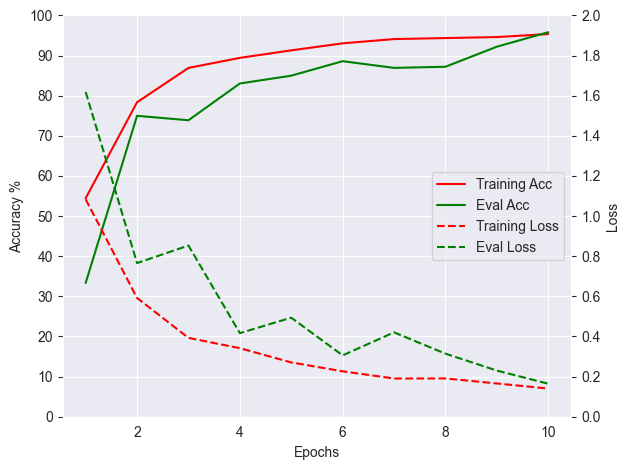

In [98]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy %')
tr_acc, = ax1.plot(range(1, num_epochs+1), train_acc, linestyle='-', color='r')
eval_acc, = ax1.plot(range(1, num_epochs+1), val_acc, linestyle='-', color='g')
ax1.set_yticks(np.arange(101, step=10))

ax2 = ax1.twinx()
ax2.set_ylabel('Loss')
tr_loss, = ax2.plot(range(1, num_epochs+1), train_loss, linestyle='--', color='r')
eval_loss, = ax2.plot(range(1, num_epochs+1), val_loss, linestyle='--', color='g')
ax2.set_yticks([.0, .2, .4, .6, .8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
ax2.grid(False)

plt.legend([tr_acc, eval_acc, tr_loss, eval_loss], ['Training Acc', 'Eval Acc', 'Training Loss', 'Eval Loss'], loc='center right')
fig.tight_layout()
plt.savefig('Learning_cross-subject_10epoch.png')

In [72]:
eval_model = RA_GCN((6, 90, 17, 1), num_class, A, 0.5, [5,2], model_stream).to(DEVICE)
eval_model = nn.DataParallel(eval_model)
eval_model.load_state_dict(torch.load(PATH))
eval_model.eval()

DataParallel(
  (module): RA_GCN(
    (stgcn_stream): ModuleList(
      (0-2): 3 x ST_GCN(
        (data_bn): BatchNorm1d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (st_gcn_networks): ModuleList(
          (0): st_gcn_layer(
            (gcn): SpatialGraphConv(
              (conv): Conv2d(6, 192, kernel_size=(1, 1), stride=(1, 1))
            )
            (tcn): Sequential(
              (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (1): ReLU()
              (2): Dropout(p=0.5, inplace=False)
              (3): Conv2d(64, 64, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
              (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (relu): ReLU(inplace=True)
          )
          (1-3): 3 x st_gcn_layer(
            (gcn): SpatialGraphConv(
              (conv): Conv2d(64, 192, kernel_size=(1, 1), stride=(1, 1))
            )
     

In [73]:
input_data = np.load("../data/hri_keypoints_robert.npy", allow_pickle=True)
labels = np.load("../data/hri_labels_robert.npy")
num = 12

# val_dataset = NTU('/content/drive/MyDrive/HRI_gestures/skeletons/', 'train', 0.8, (2, 90, 17, 1), transform=transform, mode='cross-person')

for example in range(len(labels)):
  if example == 12:
    continue
  x = np.zeros((2, 90, 17, 1))
  for frame in range(len(input_data[example])):
    for i in range(17):
      x[0, frame, i, 0] = input_data[example][frame][i][0]
      x[1, frame, i, 0] = input_data[example][frame][i][1]
  x = transform(x)
  x = torch.from_numpy(x).float()
  x = x[None,:,:,:,:]
  x = x.to(DEVICE)
  out, _ = eval_model(x)
  pred = out.max(1, keepdim=True)[1]
  print(f'output: {pred}, output label: {labels_to_learn[pred]}')
  print(f'label: {labels[example]}')

output: tensor([[1]]), output label: Standing Still
label: Come Here
output: tensor([[2]]), output label: Follow me
label: Follow Me
output: tensor([[1]]), output label: Standing Still
label: Follow Me
output: tensor([[2]]), output label: Follow me
label: Follow Me
output: tensor([[1]]), output label: Standing Still
label: Follow Me
output: tensor([[2]]), output label: Follow me
label: Get Attention
output: tensor([[0]]), output label: Stop
label: Get Attention
output: tensor([[0]]), output label: Stop
label: Get Attention
output: tensor([[2]]), output label: Follow me
label: Go Left
output: tensor([[2]]), output label: Follow me
label: Go Left
output: tensor([[2]]), output label: Follow me
label: Go Right
output: tensor([[2]]), output label: Follow me
label: Go Right
output: tensor([[2]]), output label: Follow me
label: Standing Still
output: tensor([[0]]), output label: Stop
label: Standing Still
output: tensor([[0]]), output label: Stop
label: Stop
output: tensor([[0]]), output labe

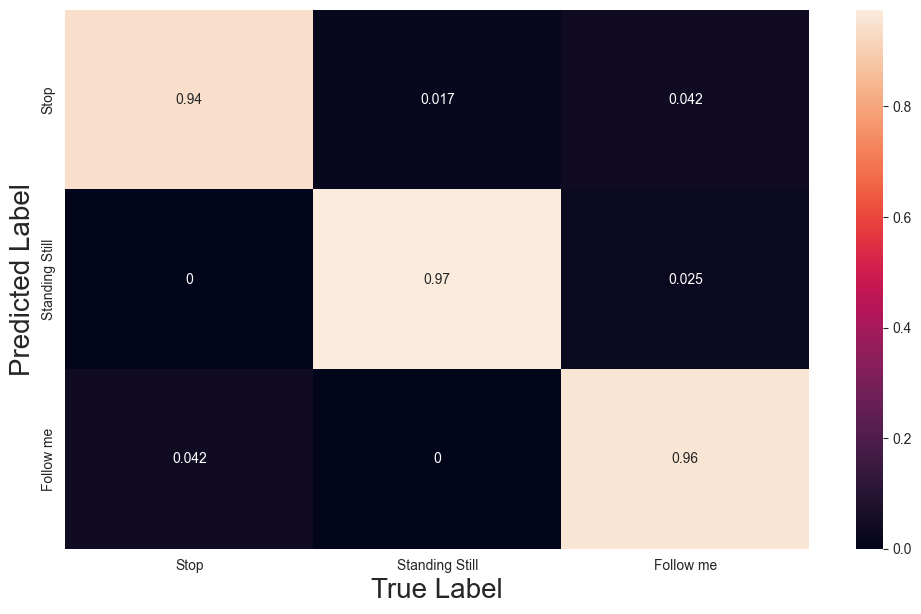

In [74]:
import pandas as pd
import seaborn as sn

y_pred = []
y_true = []

# iterate over test data
for num, (x, _, y, _) in enumerate(eval_loader):

    # Using GPU
    x = x.to(DEVICE)
    y = y.to(DEVICE)

    # Calculating Output
    output, _ = model(x)
    
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    
    labels = y.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in labels_to_learn],
                     columns = [i for i in labels_to_learn])
plt.figure(figsize = (12,7))
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
s = sn.heatmap(df_cm, annot=True)
s.set_xlabel('True Label', fontsize=20)
s.set_ylabel('Predicted Label', fontsize=20)
plt.savefig('cross-subject_10epoch.png')

In [75]:
num_classes = [0, 0, 0]
num_training = [0, 0, 0]
num_eval = [0, 0, 0]

for _, _, label, _ in train_loader:
    for idx in label:
        num_classes[idx] += 1
        num_training[idx] += 1
for _, _, label, _ in eval_loader:
    for idx in label:
        num_classes[idx] += 1
        num_eval[idx] += 1
    
print(num_classes)
print(num_training)
print(num_eval)

[664, 668, 628]
[544, 548, 508]
[120, 120, 120]
